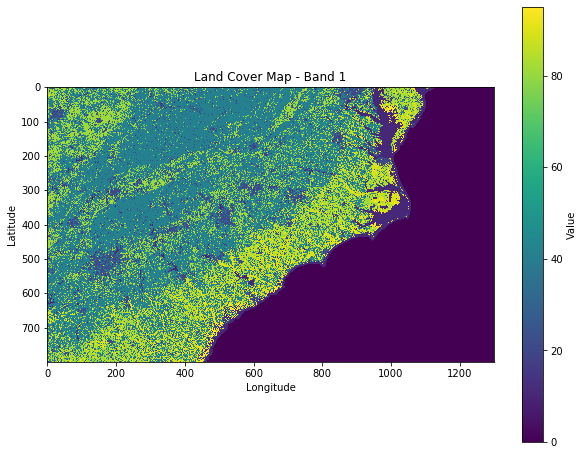

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
# File path to the .tif file
#why does 0.001 not work?
file_path = "/shared_space/ACV/nlcd_nc0.1.tif"

# Open the .tif file
with rasterio.open(file_path) as src:
    # Read a specific band (e.g., the first band)
    band1 = src.read(1)

    # Plot the band
    plt.figure(figsize=(10, 8))
    plt.imshow(band1, cmap="viridis")
    plt.colorbar(label="Value")
    plt.title("Land Cover Map - Band 1")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [10]:
import rasterio

import geopandas as gpd

# Load the elevation data (GeoTIFF)
cost_file = '/shared_space/ACV/nlcd_nc0.1.tif'
with rasterio.open(cost_file) as src:
    cost_data = src.read(1)  # Read the elevation band
    cost_transform = src.transform
    cost_crs = src.crs

# Ensure the counties and elevation CRS match (both should be EPSG:4326)
print(cost_crs)
shapefile_path = "/data/HW/HW2/NCDOT_County_Boundaries.shp"
counties = gpd.read_file(shapefile_path)
counties_reprojected = counties.to_crs(epsg=4326)

EPSG:4326


In [11]:
from rasterio.features import geometry_mask
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import rasterio.mask

# Function to calculate statistics for a given county
def calculate_stats(county, src, transform):
    # Mask the elevation data using the county polygon
    geometry = [county['geometry']]
    out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
    
    # Remove masked NoData values (-99999)
    masked_data = np.ma.masked_equal(out_image, -99999)
    
    # Calculate mean, standard deviation, and coefficient of variation
    mean_cost = np.mean(masked_data)
    max_cost = np.max(masked_data)
    std_cost = np.std(masked_data)
   # cv_wind = std_wind / mean_wind if mean_wind != 0 else 0
    
    return mean_cost, max_cost, std_cost

# Open the wind file and compute statistics for each county
with rasterio.open(cost_file) as src:
    results = []
    for idx, county in counties_reprojected.iterrows():
        mean_cost, std_cost, max_cost = calculate_stats(county, src, cost_transform)
        results.append({
            'County': county['CountyName'],
            'Mean Cost': mean_cost,
            'Max Cost': max_cost,
            'Std Cost': std_cost
           # 'CV Wind': cv_wind
        })

results_gdf = gpd.GeoDataFrame(results)
print(results_gdf)

       County  Mean Cost   Max Cost  Std Cost
0      Camden  16.482898  33.036996        95
1       Gates  43.118373  37.082566        95
2     Iredell  31.646962  30.436685        95
3      Wilkes  28.574669  25.768685        90
4       Union  38.946983  32.101633        95
..        ...        ...        ...       ...
95      Surry  38.068627  27.490356        90
96   Hertford  33.514741  35.158382        95
97     Stokes  40.181085  22.857526        90
98       Ashe  28.866106  25.634984        90
99  Alleghany  30.517787  29.262217        82

[100 rows x 4 columns]


/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


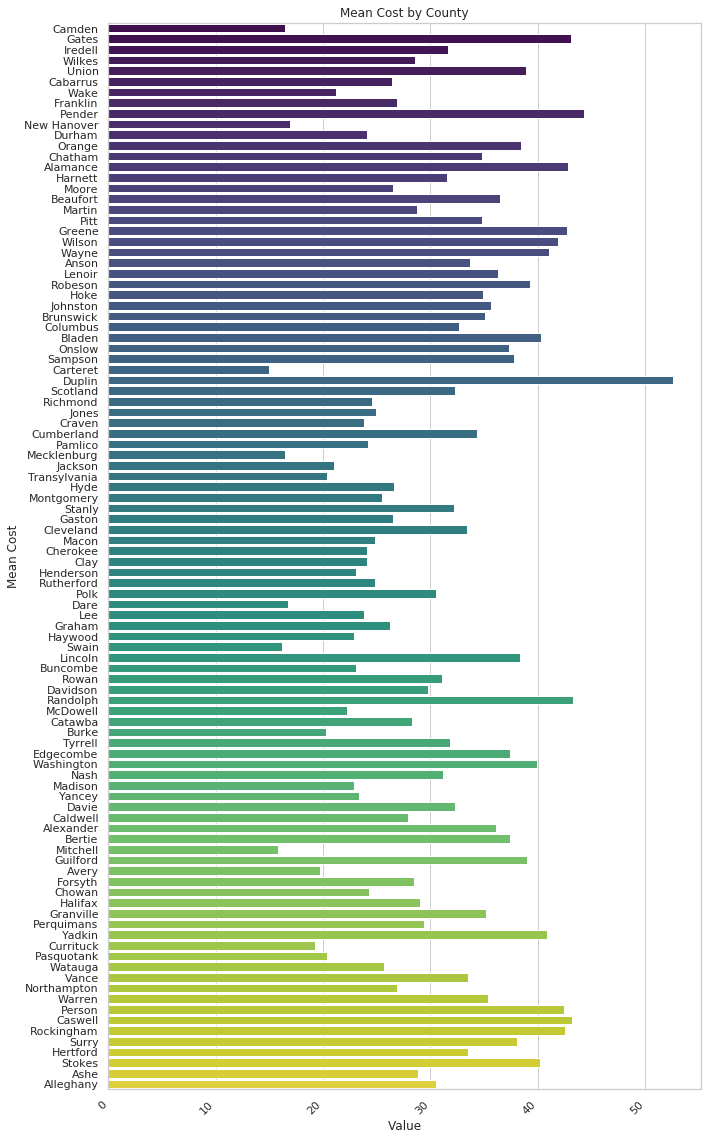

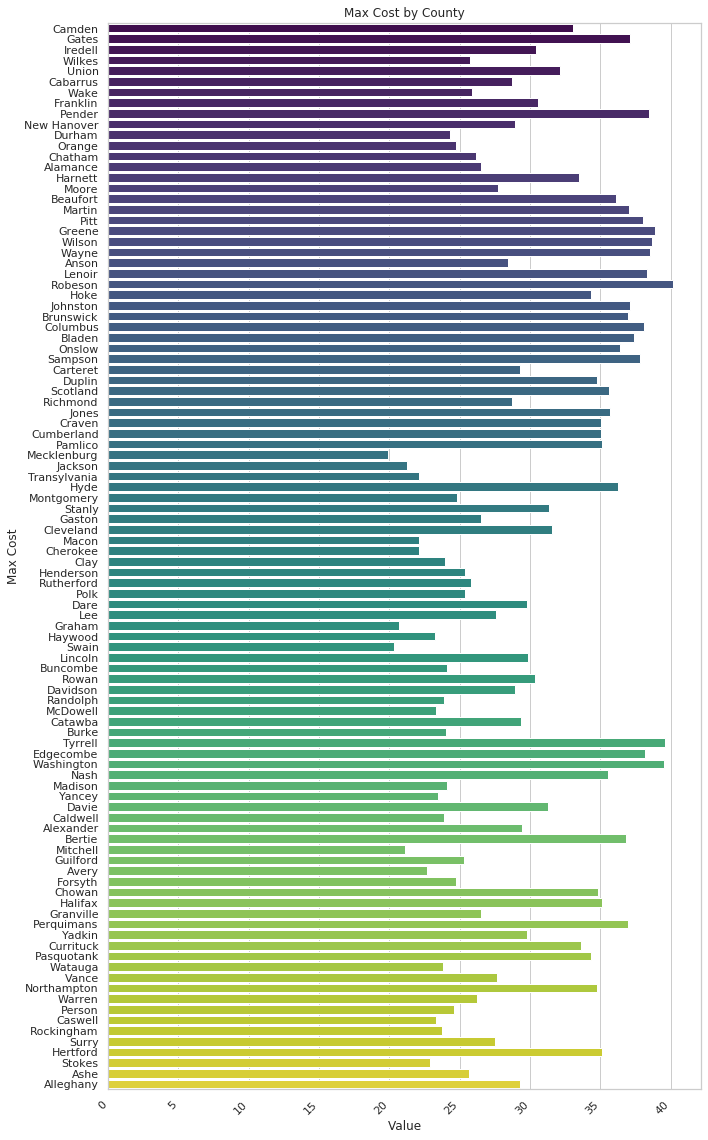

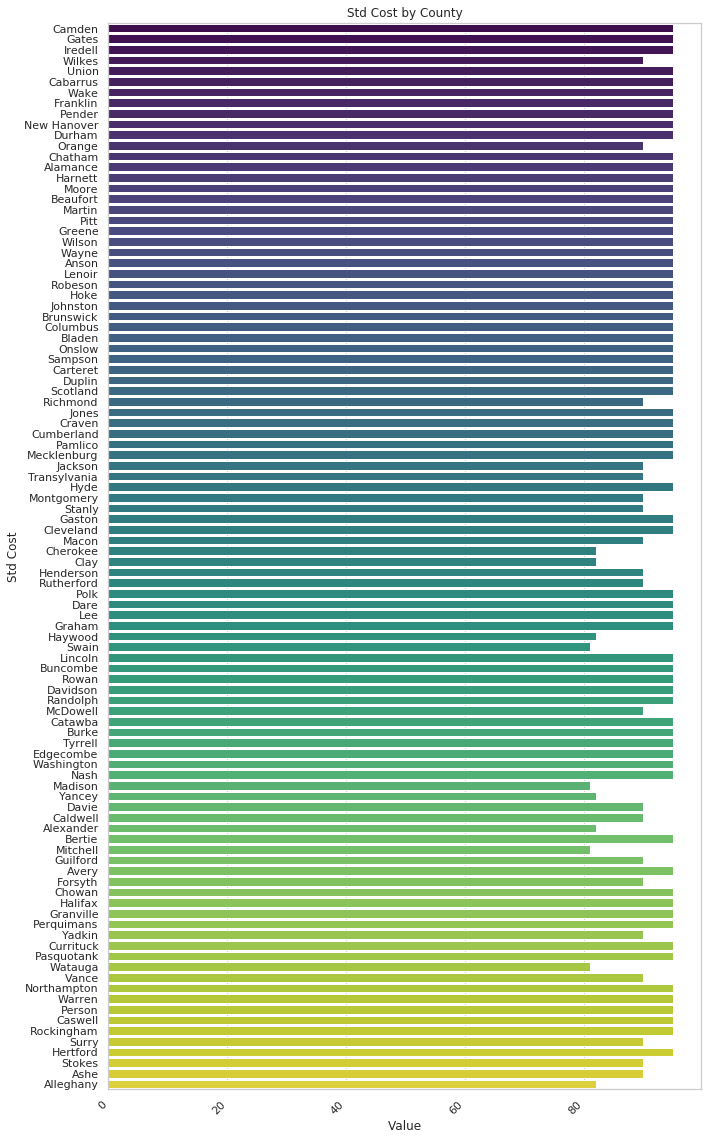

In [12]:
import seaborn as sns
#Once this database is assembled, use bar plots to show the results across all the counties (one bar plot per statistic). Explain the results. 
# Set up the plot style
sns.set(style="whitegrid")

# Define the columns you want to plot
stat_columns = [ 'Mean Cost', 'Max Cost', 'Std Cost']

# Loop through each statistic and create a barplot
for stat in stat_columns:
    plt.figure(figsize=(10, 16))  # Set figure size
    sns.barplot(x=stat, y='County', data=results_gdf, palette="viridis")
    
    # Set the title and labels
    plt.title(f'{stat} by County')
    plt.xlabel('Value')
    plt.ylabel(stat)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Show the plot
    plt.tight_layout()
    plt.show()